# Importing Necessary Libraries

In [76]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import xlrd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.models import load_model
import time

%matplotlib inline

# Data Preparation

## Defining some funcitons

In [4]:
def process(image):
    
    image_og = image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    some = cv2.resize(image, (100, 100))/255
    some = some.reshape(1, 100, 100, 1)
    
    return some

# Simplifying the 'pickling' process as we'll need this quite often
def pickleIn(name):    
    # 'name' - name of the file we wish to load (should be a string, eg. 'train_batch.pickle')
    pickle_in = open(name,'rb')
    return pickle.load(pickle_in)

def pickleOut(name, to_be_stored):
    # 'name' - name of the file we wish to store (should be a string, eg. 'train_batch.pickle')
    # 'to_be_stored' - the variable of which we'll be making the "pickle" 
    pickle_out = open(name,'wb')
    pickle.dump(to_be_stored, pickle_out)
    pickle_out.close

Below have we provided 4 variables - *'x_train', 'y_train', 'x_valid', 'y_valid'*

'x_train' and 'x_valid' are 4D Tensors
'y_train' and 'y_valid' are 2D Tensors

All of them are initialized with '0'

Now to train the model we have to feed it with actual 12000 images in the form of x_train (pre-processed) and 2000 images in x_valid and their respective labels in y_train and y_labels

*Kindly refer Approach_text.pdf to know how to make the image labels*

In [ ]:
x_train = np.zeros((12000,100,100,1))
y_train = np.zeros((12000,4))
x_valid = np.zeros((2000,100,100,1))
y_valid = np.zeros((2000,4))

Google drive link to *d2c_data.tar* - https://drive.google.com/open?id=1RVoKzP6IeulTmuLRg6cgsoVEr3RcJAe-

It containes -
    *x_train.pickle*
    *y_train.pickle*
    *x_valid.pickle*
    *y_valid.pickle*

In [5]:
# Write your code here or use this code of mine #

# the Training Files
x_train = pickleIn('x_train.pickle')
y_train = pickleIn('y_train.pickle')
x_valid = pickleIn('x_valid.pickle')
y_valid = pickleIn('y_valid.pickle')

# Training Phase

## EITHER we can DIRECTLY LOAD the MODEL OR skip to 'Building our Model'

We have stored the weights in the file named *model_0038_83_1.h5*

and here is the google drive link to the model - https://drive.google.com/open?id=1Ed81aWjZ_tH_CdjbC7j2RddalnuWYpmh

In [5]:
model = load_model('model_0038_83_1.h5')

## Building our Model

In [ ]:
model = Sequential()

model.add(ZeroPadding2D(padding=(1, 1), data_format=None))

model.add(Conv2D(5, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(Conv2D(5, (2, 2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1), data_format=None))
model.add(BatchNormalization())

model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(Conv2D(30, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1600, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4))

## Compliling Our Model

In [ ]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

## Training the Model

In [ ]:
batch_size = 120
epochs = 125

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid))

score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Prediction Phase

## Test Data Preparation

*x_test* is also a 4D Tensor of size *(Number, 100, 100, 1)* where *Number* is the number of test samples one plans to give to the model to predict 

In [ ]:
Number = #Enter a number here#

x_test = np.zeros((Number, 100, 100, 1))

In [ ]:
for i in range(Number):
    
    im_loc = 'C:/location/example'
    
    x [i,:,:,:] = process(cv2.imread(im_loc))

*x_submit.pickle* has the test images mentioned in the *test.csv*

Google Drive Link - https://drive.google.com/open?id=1igc5FSytG8iZ6otXhkEyubuc9M8S4LQ5

In [ ]:
# Or use this code of mine #

x_test = pickleIn('x_submit.pickle')

In [30]:
pred = model.predict(x_test[0:2,:,:,:])

In [31]:
print(pred)

[[0.5267871  0.5094267  0.35535783 0.66509175]
 [0.50417024 0.52293444 0.7433772  0.43731084]]


## Defining Some Functions 

***iou*** would be used to calculate the Intersection over Union for bounding boxes

In [ ]:
def iou(y_true, y_pred):

    x_t = y_true[0]
    y_t = y_true[1]
    w_t = y_true[2]
    h_t = y_true[3]

    # Calculating the Co-ordinates from Center and Length Values (Actual Square)
    x1_t = ((2*x_t) - w_t)/2
    y1_t = ((2*y_t) - h_t)/2
    x2_t = ((2*x_t) + w_t)/2
    y2_t = ((2*y_t) + h_t)/2

    x_p = y_pred[0]
    y_p = y_pred[1]
    w_p = y_pred[2]
    h_p = y_pred[3]

    # Calculating the Co-ordinates from center and length values (Prediction Square)
    x1_p = ((2*x_p) - w_p)/2
    y1_p = ((2*y_p) - h_p)/2
    x2_p = ((2*x_p) + w_p)/2
    y2_p = ((2*y_p) + h_p)/2

    # Calculating the co-ordinates of intersecting square
    x1 = max(x1_t,x1_p)
    y1 = max(y1_t,y1_p)
    x2 = min(x2_t,x2_p)
    y2 = min(y2_t,y2_p)

    # Area of Intersection
    I_area = (x2-x1)*(y2-y1)

    true_area = (x2_t-x1_t)*(y2_t-y1_t)
    pred_area = (x2_p-x1_p)*(y2_p-y1_p)

    # Union of both regions
    U_area = true_area + pred_area - I_area

    # Intersection over Union
    IOU = I_area/U_area

    return IOU

If given the location of a particular image then we can use the following definition over the image

In [110]:
def predict_1x100x100x1(image):
    
    some = image[i,:,:,:]

    plt.imshow(some.reshape(100,100))
    plt.plot(100*pred[i,0],100*pred[i,1],'ro')

    x1_ = 100*((2*pred[i,0]) - pred[i,2])/2
    y1_ = 100*((2*pred[i,1]) - pred[i,3])/2
    x2_ = 100*((2*pred[i,0]) + pred[i,2])/2
    y2_ = 100*((2*pred[i,1]) + pred[i,3])/2

    plt.plot(x1_,y1_,'ro')
    plt.plot(x2_,y2_,'ro')
    plt.plot(x1_,y2_,'ro')
    plt.plot(x2_,y1_,'ro')
    
def predict_640x480x3(image, model):
    
    # image - is the original image without any preprocessing step
    # model - is the model we used to train
    start = time.time()
    pred = model.predict(process(image))
    end = time.time()

    x1_ = 640*((2*pred[0,0]) - pred[0,2])/2
    y1_ = 480*((2*pred[0,1]) - pred[0,3])/2
    x2_ = 640*((2*pred[0,0]) + pred[0,2])/2
    y2_ = 480*((2*pred[0,1]) + pred[0,3])/2
    
    '''cv2.imshow('hi',image)
    '''
    
    cv2.rectangle(image, (int(x1_),int(y1_)), (int(x2_),int(y2_)),(0,0,255),3)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    print(end - start)
    
    '''plt.plot(640*pred[0,0], 480*pred[0,1],'ro')
    
    plt.plot(x1_,y1_,'ro')
    plt.plot(x2_,y2_,'ro')
    plt.plot(x1_,y2_,'ro')
    plt.plot(x2_,y1_,'ro')'''

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_11 (ZeroPaddi (None, 102, 102, 1)       0         
_________________________________________________________________
conv2d_784 (Conv2D)          (None, 101, 101, 5)       25        
_________________________________________________________________
conv2d_785 (Conv2D)          (None, 100, 100, 5)       105       
_________________________________________________________________
batch_normalization_99 (Batc (None, 100, 100, 5)       20        
_________________________________________________________________
conv2d_786 (Conv2D)          (None, 99, 99, 10)        210       
_________________________________________________________________
conv2d_787 (Conv2D)          (None, 98, 98, 10)        410       
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 100, 100, 10)      0         
__________

# Writing into *test.csv*

In [ ]:
pred_submit = model_1.predict(x_submit) 

We first wrote the prediction values in *submit.xls* then copied the cells in *test.csv* and uploaded it on the portal

In [ ]:
import xlwt

wb = xlwt.Workbook()

ws = wb.add_sheet("Sheet1")

ws.write(0,0,"x1")
ws.write(0,1,"x2")
ws.write(0,2,"y1")
ws.write(0,3,"y2")

for i in range(12815):
    
    x1_ = 640*((2*pred_submit[i,0]) - pred_submit[i,2])/2
    y1_ = 480*((2*pred_submit[i,1]) - pred_submit[i,3])/2
    x2_ = 640*((2*pred_submit[i,0]) + pred_submit[i,2])/2
    y2_ = 480*((2*pred_submit[i,1]) + pred_submit[i,3])/2
    
    ws.write(i+1,0,x1_)
    ws.write(i+1,1,x2_)
    ws.write(i+1,2,y1_)
    ws.write(i+1,3,y2_)
    
wb.save("submit.xls")

In [67]:
import cv2

## Working of *predict_640x480x3(image, model)*

- read an *image* from computer and then feed it, along with the *model*
- it will output an image with bounding box co-ordinates marked over it

0.1534886360168457


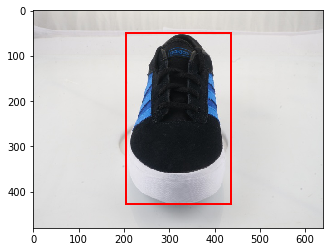

In [160]:
name = "1474640473704DSC07045.png"
loc = ["C:\\Users\\npl\\Desktop\\Divyanshu\\Competition\\Dare2Complete\\Round_2\\images\\",name]
loc = ''.join(loc)
image = cv2.imread(loc)

# Evaluator can give any image location the above is just an example...
# but the model has to either be trained or loaded from Google drive link

predict_640x480x3(image, model)